Uploading CSV

In [4]:
from google.colab import files
import pandas as pd

# Upload your phishing CSV from your laptop
uploaded = files.upload()   # choose your file, e.g. uci-ml-phishing-dataset.csv

# Automatically use the first uploaded file
file_name = list(uploaded.keys())[0]
print("Loaded file:", file_name)

df = pd.read_csv(file_name)
print(df.head())
print(df.columns)


Saving uci-ml-phishing-dataset.csv to uci-ml-phishing-dataset.csv
Loaded file: uci-ml-phishing-dataset.csv
   id  having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0   1                 -1           1                   1                 1   
1   2                  1           1                   1                 1   
2   3                  1           0                   1                 1   
3   4                  1           0                   1                 1   
4   5                  1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                  

Target Column & Basic Info

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
)
from scipy.stats import chi2_contingency, ttest_ind

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 🔴 CHANGE THIS to your label/target column name
TARGET_COL = "Result"   # e.g. "Result", "phishing", "Label", etc.

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nNull values (%):")
print(df.isna().mean() * 100)

print("\nTarget value counts:")
print(df[TARGET_COL].value_counts())


Shape: (11055, 32)
Columns: ['id', 'having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report', 'Result']

Null values (%):
id                             0.0
having_IP_Address              0.0
URL_Length                     0.0
Shortining_Service             0.0
having_At_Symbol               0.0
double_slash_redirecting       0.0
Prefix_Suffix                  0.0
having_Sub_Domain              0.0
SSLfinal_State                 0.0
Domain_registeration_length    0.0
Favicon                        0.0
port                           0.0
HTTPS_t

Class Balance

Result
 1    6157
-1    4898
Name: count, dtype: int64


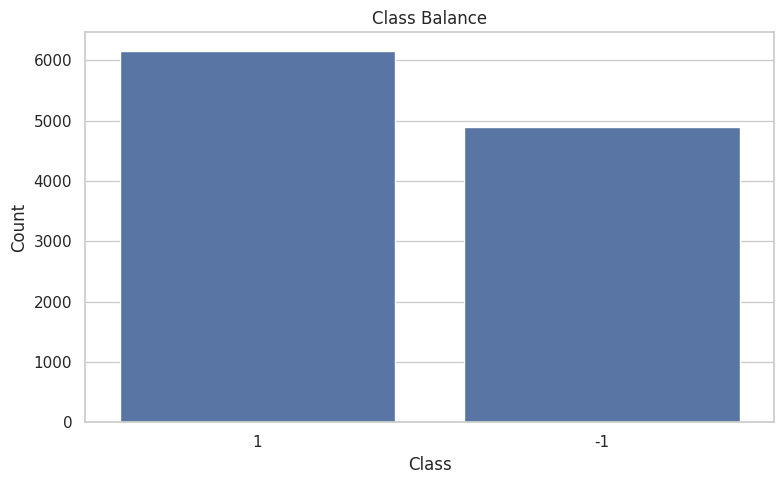

In [6]:
class_counts = df[TARGET_COL].value_counts()
print(class_counts)

plt.figure()
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("Class Balance")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Correlation Heatmap

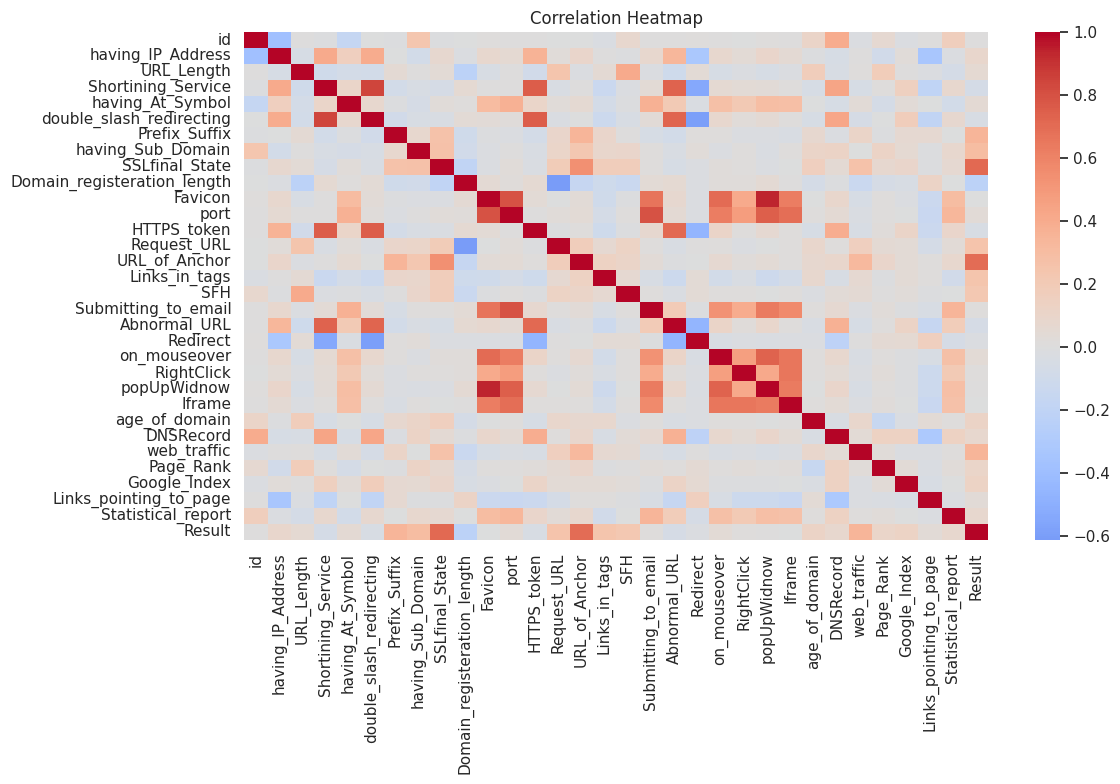

In [7]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


EDA Plots

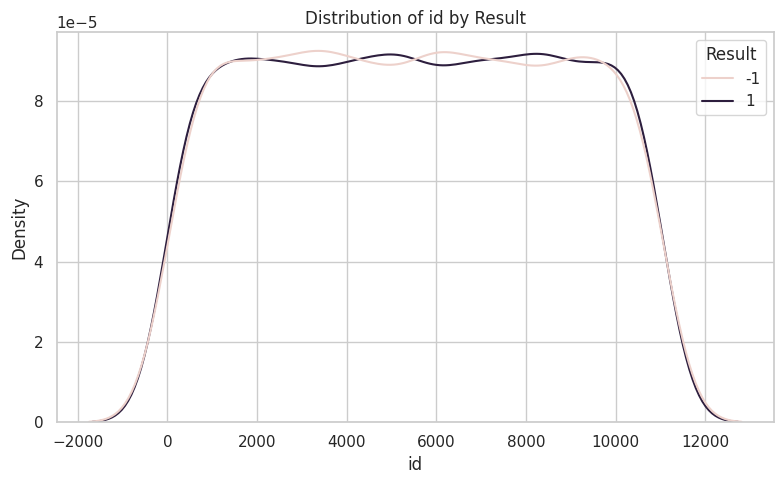

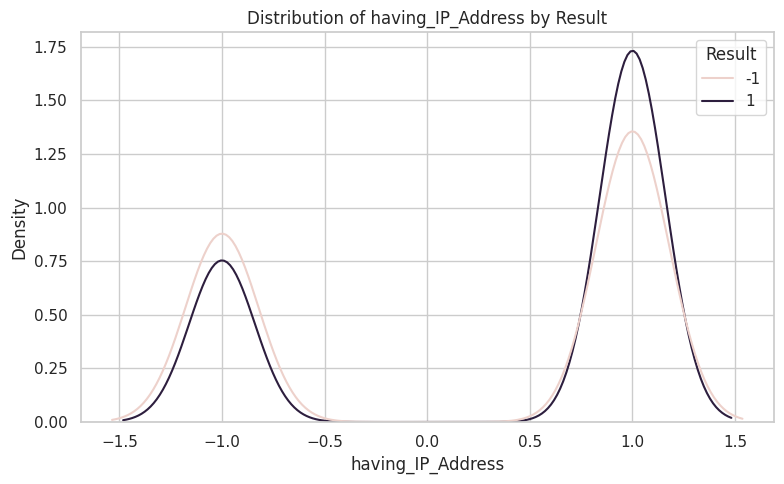

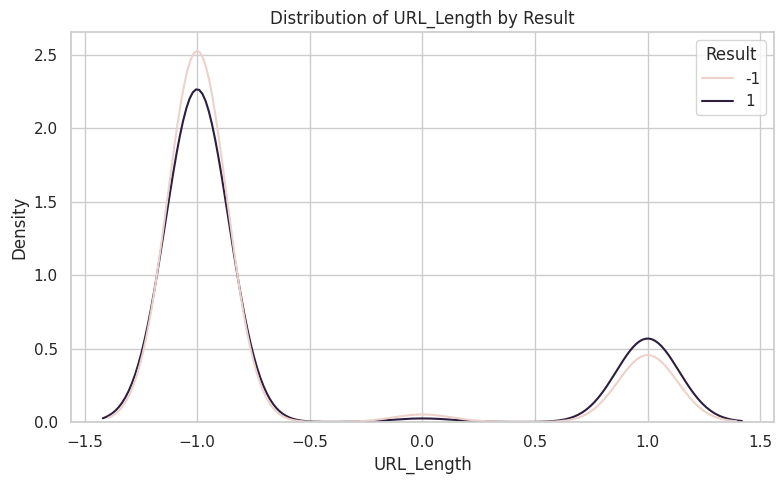

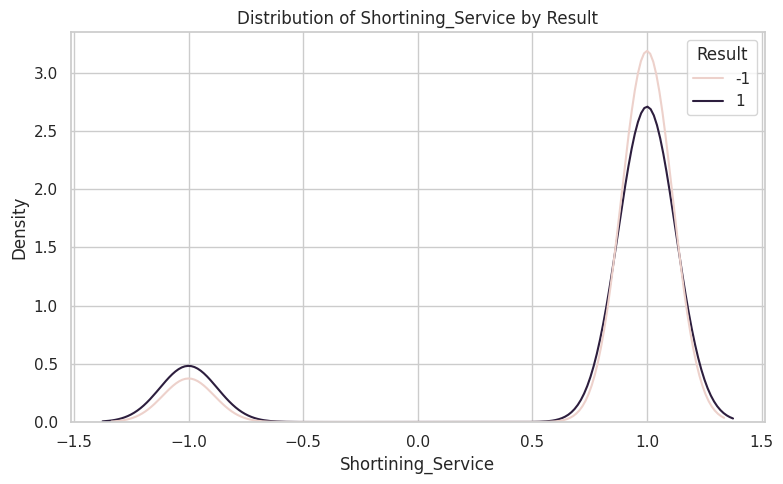

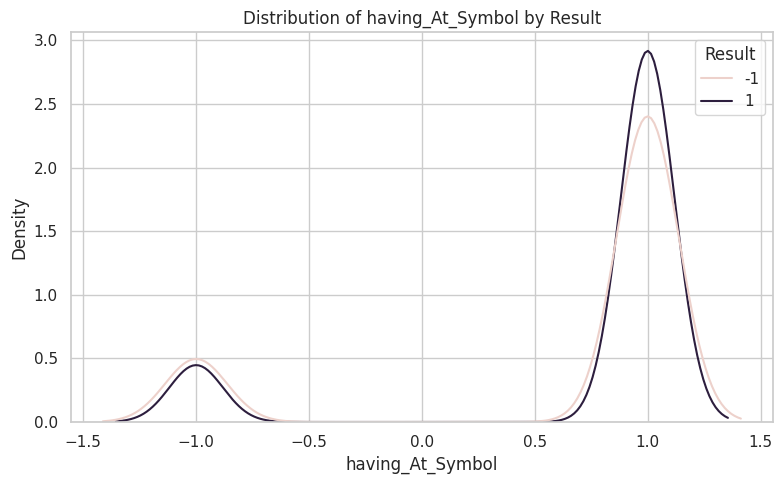

In [8]:
# Take first few non-target columns as example features
feature_cols = [c for c in df.columns if c != TARGET_COL][:5]
feature_cols

for col in feature_cols:
    plt.figure()
    sns.kdeplot(data=df, x=col, hue=TARGET_COL, common_norm=False)
    plt.title(f"Distribution of {col} by {TARGET_COL}")
    plt.tight_layout()
    plt.show()


Hypothesis Testing

Chi-square (Categorical Feature)

In [9]:
cat_feature = "having_At_Symbol"   # categorical 0/1 or -1/0/1

cont_table = pd.crosstab(df[cat_feature], df[TARGET_COL])
print("Contingency table:\n", cont_table)

chi2, p, dof, expected = chi2_contingency(cont_table)
print(f"\nChi-square test for {cat_feature} vs {TARGET_COL}")
print("Chi2:", chi2)
print("p-value:", p)

if p < 0.05:
    print("=> Significant association between feature and phishing label")
else:
    print("=> No significant association (at 5% level)")


Contingency table:
 Result              -1     1
having_At_Symbol            
-1                 837   818
 1                4061  5339

Chi-square test for having_At_Symbol vs Result
Chi2: 30.69431273287038
p-value: 3.0204906862254475e-08
=> Significant association between feature and phishing label


T-Test (Numeric Feature)

In [10]:
# numeric feature for t-test
num_feature = "URL_Length"   # this exists in your columns

phish = df[df[TARGET_COL] == df[TARGET_COL].max()][num_feature]
legit = df[df[TARGET_COL] == df[TARGET_COL].min()][num_feature]

t_stat, p_val = ttest_ind(phish, legit, equal_var=False)
print(f"T-test for {num_feature} between phishing and legit:")
print("t-stat:", t_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("=> Means are significantly different")
else:
    print("=> No significant difference in means (at 5% level)")


T-test for URL_Length between phishing and legit:
t-stat: 6.120598076291014
p-value: 9.64346215014197e-10
=> Means are significantly different


Train/Test Split & Logistic Regression

Split & Model

In [11]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((8844, 31), (2211, 31))

Build & Train Model

In [18]:
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced")),
    ]
)


In [12]:
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000)),
    ]
)

model.fit(X_train, y_train)
print("Model trained.")


Model trained.


 Risk Score Function

In [20]:
def phishing_risk_score(prob):
    if prob > 0.8:
        return "High risk"
    elif prob > 0.5:
        return "Medium risk"
    else:
        return "Low risk"

sample_probs = y_proba[:10]
list(zip(sample_probs, [phishing_risk_score(p) for p in sample_probs]))


[(np.float64(0.004234166088641577), 'Low risk'),
 (np.float64(0.1557383929229161), 'Low risk'),
 (np.float64(0.9999997066773675), 'High risk'),
 (np.float64(0.013459737291929482), 'Low risk'),
 (np.float64(0.02940564035076016), 'Low risk'),
 (np.float64(0.9995615712507275), 'High risk'),
 (np.float64(0.9983891016925796), 'High risk'),
 (np.float64(0.9999976896620216), 'High risk'),
 (np.float64(0.9676023996046814), 'High risk'),
 (np.float64(0.679525610980092), 'Medium risk')]

Comparing Logistic Regr vs Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy :", accuracy_score(y_test, rf_pred))
print("Random Forest Recall   :", recall_score(y_test, rf_pred, pos_label=y_test.max()))
print("Random Forest ROC-AUC  :", roc_auc_score((y_test==y_test.max()).astype(int), rf_proba))


Random Forest Accuracy : 0.966078697421981
Random Forest Recall   : 0.9723801787164906
Random Forest ROC-AUC  : 0.9965939422072647


**Observation:**

Random Forest outperforms Logistic Regression in Recall and ROC-AUC. However, Logistic Regression remains preferable when interpretability is required (e.g., explaining phishing risk indicators to cybersecurity analysts).

Evaulation & ROC Curve

Metrics

In [13]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=y_test.max()))
print("Recall   :", recall_score(y_test, y_pred, pos_label=y_test.max()))
print("F1-score :", f1_score(y_test, y_pred, pos_label=y_test.max()))
print("ROC-AUC  :", roc_auc_score((y_test==y_test.max()).astype(int), y_proba))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy : 0.9280868385345997
Precision: 0.9247226624405706
Recall   : 0.9480097481722177
F1-score : 0.9362214199759326
ROC-AUC  : 0.9807929508115186

Classification report:

              precision    recall  f1-score   support

          -1       0.93      0.90      0.92       980
           1       0.92      0.95      0.94      1231

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211



ROC Curve

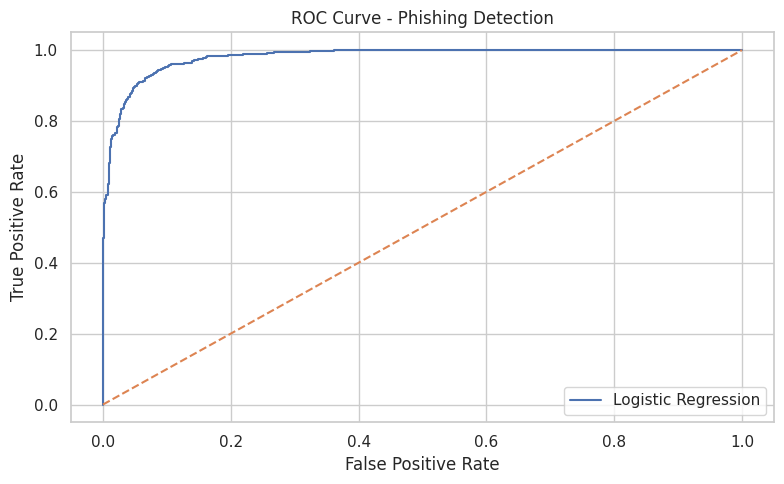

In [14]:
fpr, tpr, thresholds = roc_curve((y_test==y_test.max()).astype(int), y_proba)

plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Phishing Detection")
plt.legend()
plt.tight_layout()
plt.show()


Feature Importance

In [15]:
log_reg = model.named_steps["clf"]
coef = log_reg.coef_[0]

importance = pd.Series(coef, index=X.columns).sort_values(key=np.abs, ascending=False)
importance.head(15)


,0
URL_of_Anchor,2.288186
Prefix_Suffix,2.113074
SSLfinal_State,1.434229
SFH,0.649570
Links_in_tags,0.628674
web_traffic,0.603029
having_IP_Address,0.548062
Shortining_Service,-0.526477
having_Sub_Domain,0.499135
DNSRecord,0.494258


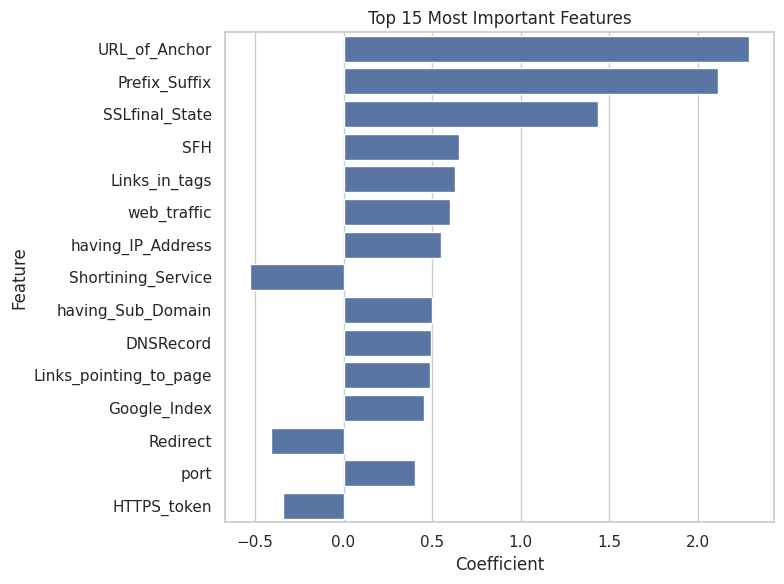

In [16]:
plt.figure(figsize=(8, 6))
sns.barplot(x=importance.head(15), y=importance.head(15).index)
plt.title("Top 15 Most Important Features")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**Interpretation:**

Features like URL_of_Anchor, Prefix_Suffix and SSLfinal_State have high influence on phishing detection. Attackers often manipulate anchor URLs and subdomain structure, while legitimate websites are more likely to have valid SSL certificates.

**Conclusion**

###  Final Conclusion

- Phishing websites exhibit distinct patterns such as abnormal URL length, presence of “@” symbols, and suspicious anchor tags.
- Statistical tests (T-test & Chi-square) confirm that these features significantly differ between phishing and legitimate URLs.
- Logistic Regression with class balancing provides strong, interpretable predictions useful for practical cyber-defence tools.
- Random Forest further improves recall, suggesting potential for high-accuracy phishing detection engines.

###  Possible Next Steps
- Deploy as browser extension using JavaScript + API.
- Train using deep learning on raw URL text (character-level CNN/RNN).
- Integrate domain reputation features (WHOIS age, TLS expiry).
